In [33]:
import math
import cv2
import numpy as np
from pupil_apriltags import Detector
import matplotlib.pyplot as plt
import matplotlib
import os

motion_name = "LeftKneePitchIsolated"

cap = cv2.VideoCapture(f"MotionVideos/{motion_name}.mp4")

# Check if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video")

# Initialize AprilTag detector
detector = Detector(families='tag25h9',
                    nthreads=1,
                    quad_decimate=1.0,
                    quad_sigma=0.0,
                    refine_edges=1,
                    decode_sharpening=0.25,
                    debug=0)

# Arrays to store trajectory
x_positions = []
y_positions = []
e_distance = []

last_valid_center = [834, 301]

MAX_MOVEMENT = 30

while True:
    # Read frame from video
    ret, frame = cap.read()
    if not ret or frame is None:
        print("End of video or failed to read frame")
        break
        
    # Adjust brightness
    brightness_factor = 1.0
    
    # Convert adjusted frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect AprilTags in the frame
    results = detector.detect(gray)

    valid_detections_0 = []
    valid_detections_1 = []
    
    for r in results:
        # Only consider detections with high decision margin (confidence)
        if r.decision_margin > 0.999:  # Adjust this threshold as needed
            tag_id = r.tag_id
            center = tuple(int(c) for c in r.center)

            if tag_id == 1:
                # Check if movement is physically possible
                valid_detections_1.append((tag_id, center, r.corners.astype(int)))
            if tag_id == 0:
                valid_detections_0.append((tag_id, center, r.corners.astype(int)))
        
    # Draw detection results and store positions

    if len(valid_detections_1) > 0:
        tag_id, center, corners = valid_detections_1[0]
        # Store positions
        center_1 = center
    
        # Draw the tag outline
        cv2.polylines(gray, [corners], True, (0, 255, 0), 2)
        
        # Draw the tag center
        cv2.circle(gray, center, 5, (0, 0, 255), -1)
        
        # Put the tag ID near the center
        cv2.putText(gray, f"ID:{tag_id}", (center[0] - 10, center[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    if len(valid_detections_0) > 0:
        tag_id, center, corners = valid_detections_0[0]
        # Draw the tag outline
        center_0 = center

        cv2.polylines(gray, [corners], True, (0, 255, 0), 2)
        
        # Draw the tag center
        cv2.circle(gray, center, 5, (0, 0, 255), -1)
        
        # Put the tag ID near the center
        cv2.putText(gray, f"ID:{tag_id}", (center[0] - 10, center[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    if center_0 is not None and center_1 is not None:
        e_distance.append(math.sqrt((center_0[0] - center_1[0])**2 + (center_0[1] - center_1[1])**2))
    
    # Display the adjusted frame
    cv2.imshow('AprilTag Detection', gray)

    # Add waitKey to actually show the frame
    if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to quit
        break

# Release everything
cap.release()
cv2.destroyAllWindows()

End of video or failed to read frame


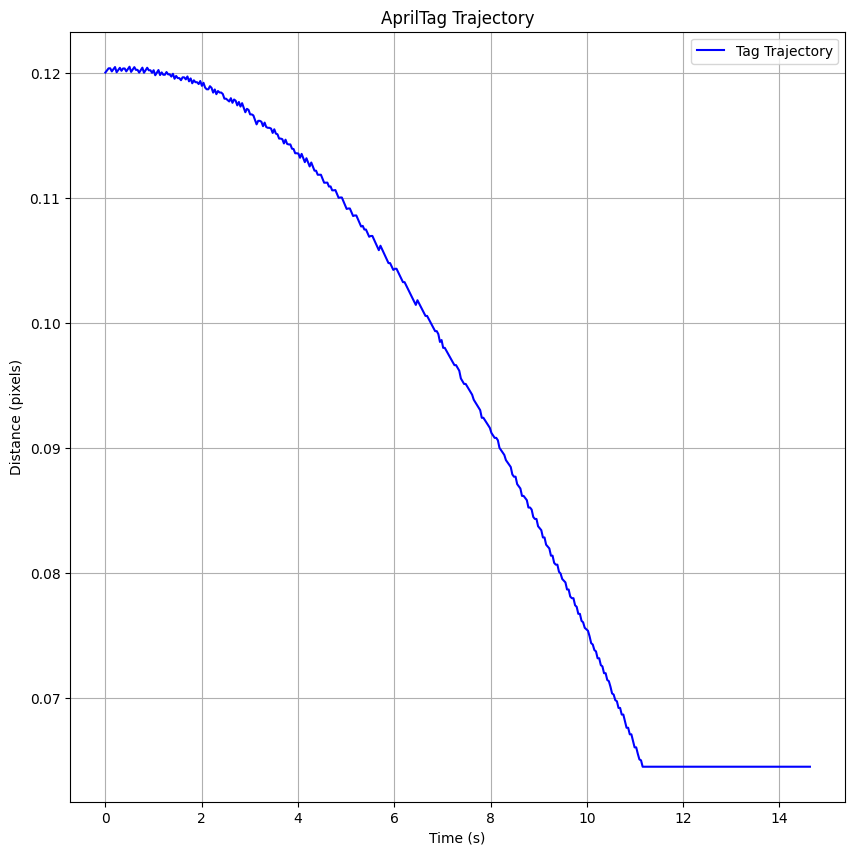

In [34]:
fps = 30

start_frame = 117
e_distance = e_distance[start_frame:]

times = np.linspace(0, len(e_distance) / fps, len(e_distance))

pixels_start_pos = e_distance[0]
meter_start_pos = 0.12

meter_per_pixel = meter_start_pos / pixels_start_pos

e_distance_m = [e_distance[i] * meter_per_pixel for i in range(len(e_distance))]

plt.figure(figsize=(10, 10))
plt.plot(times, e_distance_m, 'b-', label='Tag Trajectory')
plt.title('AprilTag Trajectory')    
plt.xlabel('Time (s)')
plt.ylabel('Distance (pixels)')
plt.legend()
plt.grid(True)

plt.show()

In [35]:
video_name = os.path.splitext(os.path.basename(f"MotionVideos/{motion_name}.csv"))[0]

# Create Trajectories directory if it doesn't exist
trajectories_dir = "Trajectories"
if not os.path.exists(trajectories_dir):
    os.makedirs(trajectories_dir)

# Save trajectory data to file
trajectory_file = os.path.join(trajectories_dir, f"{video_name}.txt")
with open(trajectory_file, 'w') as f:
    f.write("Time(s),Distance(m)\n")
    for t, d in zip(times, e_distance_m):
        f.write(f"{t:.3f},{d:.6f}\n")

print(f"Trajectory data saved to {trajectory_file}")


Trajectory data saved to Trajectories/LeftKneePitchIsolated.txt
